### Imports

In [27]:
%pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from pandas import DatetimeIndex

pd.set_option('display.max_columns', 500)

%matplotlib inline

# Carregamento de dados

In [29]:
df = pd.read_excel('Global_Superstore2.xlsx', index_col=0, comment='#') 

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51290 entries, 32298 to 6147
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Order ID        51290 non-null  object 
 1   Order Date      51290 non-null  object 
 2   Ship Date       51290 non-null  object 
 3   Ship Mode       51290 non-null  object 
 4   Customer ID     51290 non-null  object 
 5   Customer Name   51290 non-null  object 
 6   Segment         51290 non-null  object 
 7   City            51290 non-null  object 
 8   State           51290 non-null  object 
 9   Country         51290 non-null  object 
 10  Postal Code     9994 non-null   float64
 11  Market          51290 non-null  object 
 12  Region          51290 non-null  object 
 13  Product ID      51290 non-null  object 
 14  Category        51290 non-null  object 
 15  Sub-Category    51290 non-null  object 
 16  Product Name    51251 non-null  object 
 17  Sales           51200 non-nu

In [31]:
df.head(2)

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Country,Postal Code,Market,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
Row ID,,,,,,,,,,,,,,,,,,,,,,,
32298,CA-2012-124891,31-07-2012,31-07-2012,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,United States,10024.0,US,East,TEC-AC-10003033,Technology,Accessories,Plantronics CS510 - Over-the-Head monaural Wir...,2309.650,7.0,0.0,762.1845,933.57,Critical
26341,IN-2013-77878,05-02-2013,07-02-2013,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,Australia,NaN,APAC,Oceania,FUR-CH-10003950,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9.0,0.1,-288.7650,923.63,Critical


### Converão de dados para os dtypes corretos
Podemos verificar que o data frame resultante da leitura do ficheiro não resulta nos dtypes esperados. Por exemplo, a coluna com datas foram convertidas para object, e o postal code foi reconhecido como float (apesar de ser melhor trabalhado como object, por nao ser poder ser agregado). 

In [32]:
df[['Order Date','Ship Date']] = df[['Order Date','Ship Date']].apply(pd.to_datetime, format='%d-%m-%Y')
df[['Postal Code']] = df[['Postal Code']].astype("object")

### Exploração dos dados

In [33]:
print("This dataset has {} columns and {} rows".format(df.shape[1],df.shape[0]))

This dataset has 23 columns and 51290 rows


##### Describe object (string) columns

In [34]:
df.describe(include=[object])

,Order ID,Ship Mode,Customer ID,Customer Name,Segment,City,State,Country,Postal Code,Market,Region,Product ID,Category,Sub-Category,Product Name,Order Priority
count,51290,51290,51290,51290,51290,51290,51290,51290,9994.0,51290,51290,51290,51290,51290,51251,51200
unique,25035,4,1590,795,3,3636,1094,147,631.0,7,13,10292,3,17,3781,4
top,CA-2014-100111,Standard Class,PO-18850,Muhammed Yedwab,Consumer,New York City,California,United States,10035.0,APAC,Central,OFF-AR-10003651,Office Supplies,Binders,Staples,Medium
freq,14,30775,97,108,26518,915,2001,9994,263.0,11002,11117,35,31273,6152,227,29386


##### Conclusions from datafram description of object values:
1. The number of unique **Order ID** values is lower then the total number of rows in the dataframe. This means that a single order is spread in multiple rows.
2. From the description of the object columns, we can see that the columns **Ship Mode**, **Segment**, **Market**, **Region**, **Category**, **Sub-Category** and **Order Priority** all have less then 20 unique values, out of over 51k total values. We can assume that these are categoriacal varibales.
3. There are more unique **Product ID** then **Product Name**, so different products have the same name.

##### Describe numerical columns

In [35]:
df.describe()

,Sales,Quantity,Discount,Profit,Shipping Cost
count,51200.000000,51200.000000,51200.000000,51200.000000,51200.000000
mean,246.865006,3.476426,0.143026,28.639338,26.416522
std,487.908698,2.278923,0.212409,174.491125,57.338685
min,0.444000,1.000000,0.000000,-6599.978000,0.000000
25%,30.880000,2.000000,0.000000,0.000000,2.620000
50%,85.273800,3.000000,0.000000,9.255100,7.810000
75%,251.640000,5.000000,0.200000,36.841500,24.530000
max,22638.480000,14.000000,0.850000,8399.976000,933.570000


##### Conclusions from datafram description of numerical values:
1. The column **Discount** is between 0 and 0.85, indicating it represents a percentage.
2. The column **Profit** represents an absolute value that can be negative. It has a very broad range of values.
3. The max quantity of items in each row is 14, yet the value in **Sales** has a very broad range, meaning the price of individual products is very diverse.

### Análise Visual dos dados

#### Distribuição das varivaies categóricas

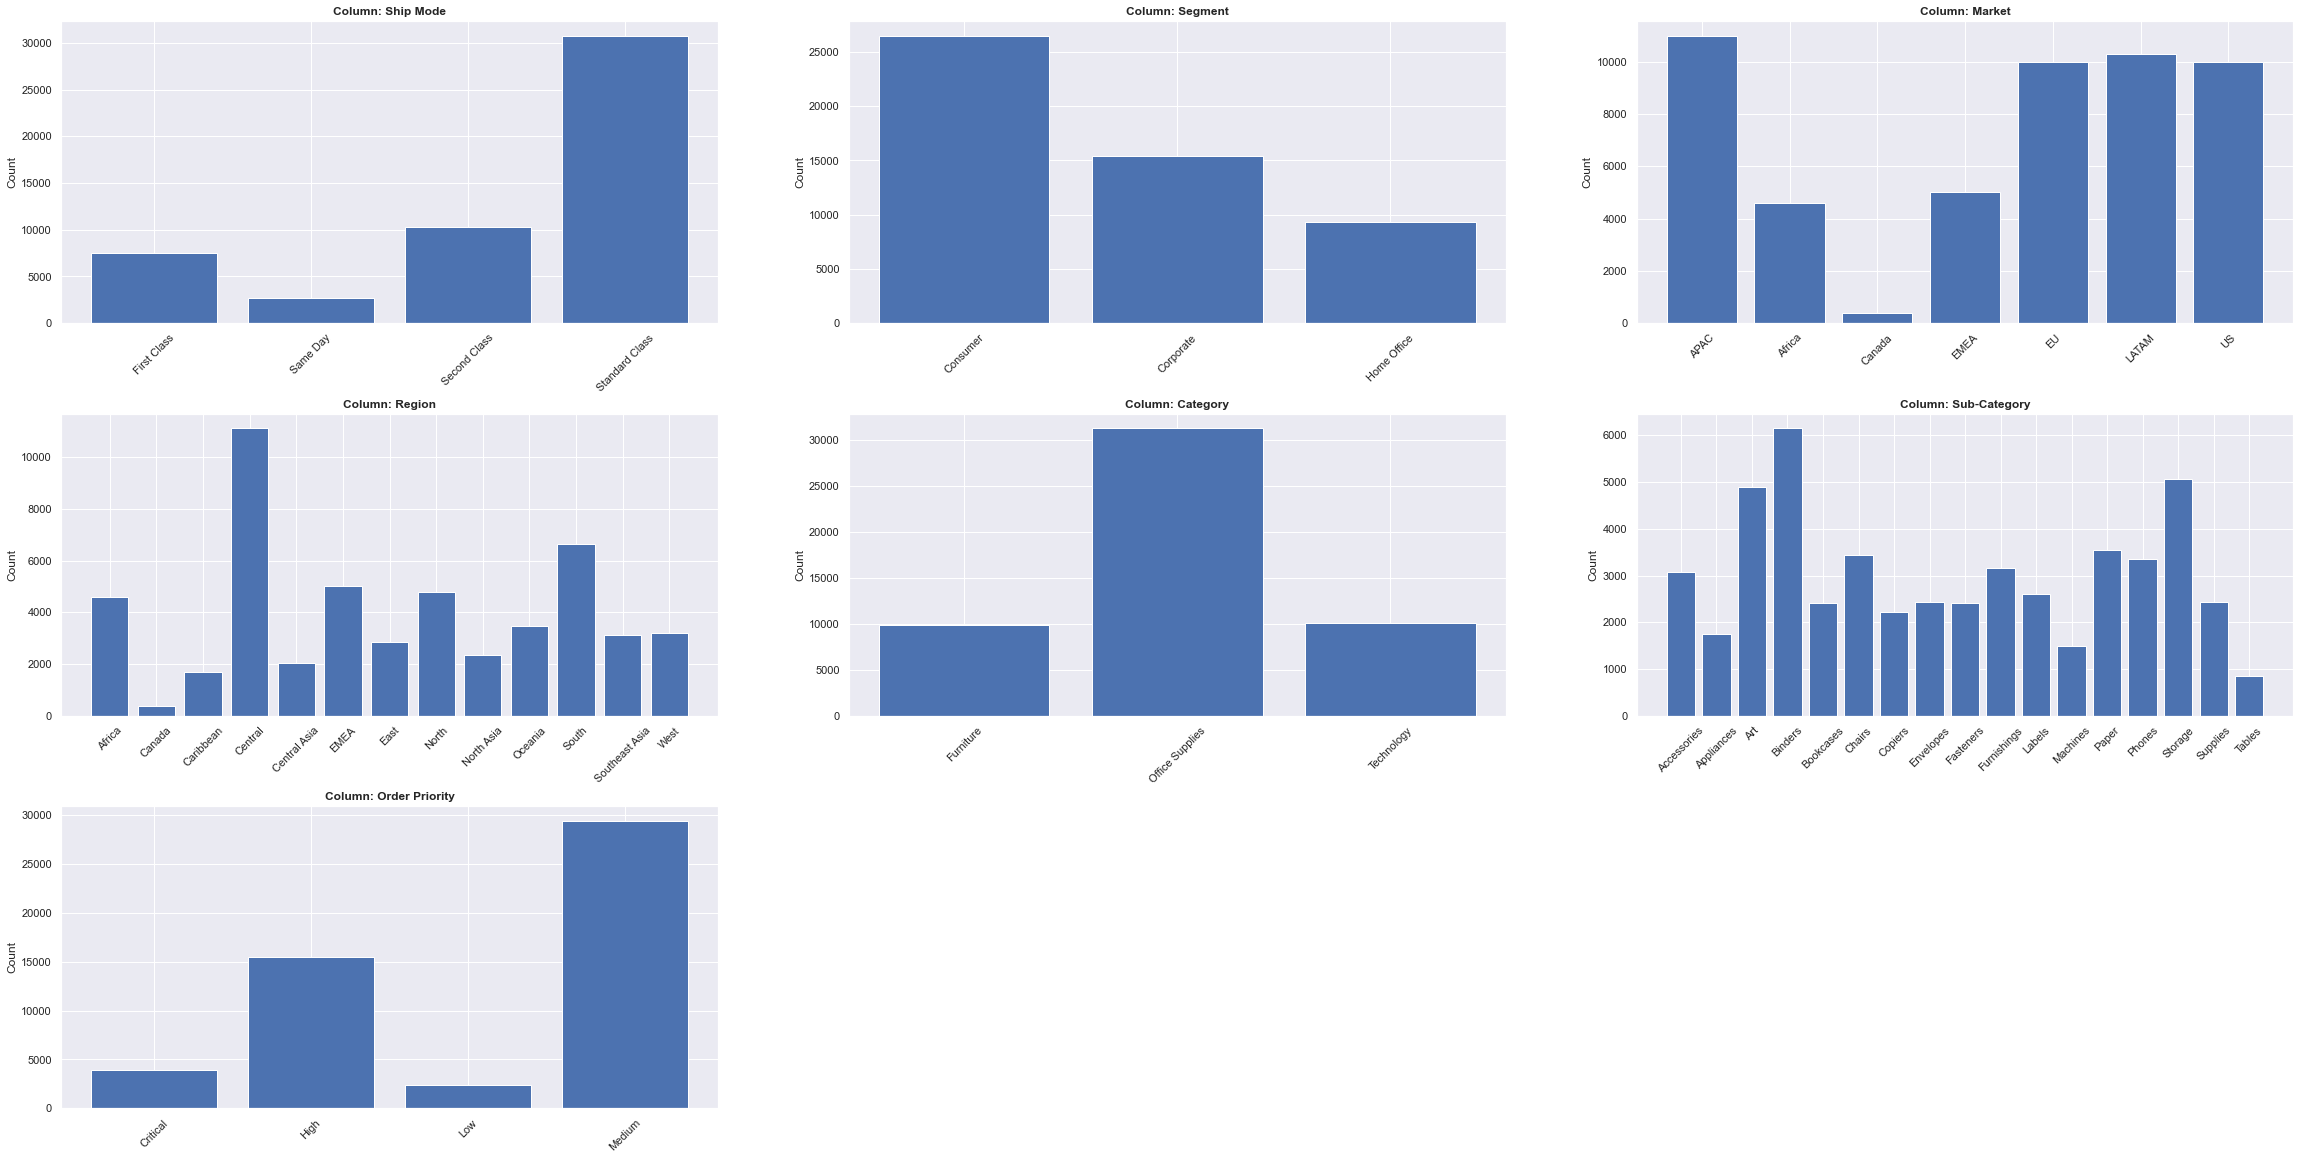

In [36]:
cols = ["Ship Mode", "Segment", "Market", "Region", "Category", "Sub-Category", "Order Priority"]
fig_nr_columns = 3
fig_nr_rows = 1 + (len(cols) // fig_nr_columns) if len(cols) % fig_nr_columns != 0 else len(cols) // fig_nr_columns
fig = plt.figure(1, figsize=[40,20])

for k in range(len(cols)):
    data_agg = df.groupby(cols[k]).size().reset_index()
    x = data_agg[cols[k]]
    y = data_agg[0]
    ypos = np.arange(len(x))
    #ypos = np.arange(len(x))
    ax = fig.add_subplot(fig_nr_rows, fig_nr_columns, k+1)
    plt.subplots_adjust(hspace=0.3, wspace=0.2)
    ax.bar(ypos, y)
    ax.tick_params(axis='x', rotation=45)
    plt.xticks(ypos, x)
    plt.title("Column: {}".format(cols[k]), fontweight='bold')
    plt.ylabel("Count")

plt.show()

##### We can clearly see that none of the categories are well distributed. For example, most sales are under the Office Supplies category and they are, which may complicate using it in the models

#### Distribuição das varivaies numéricas

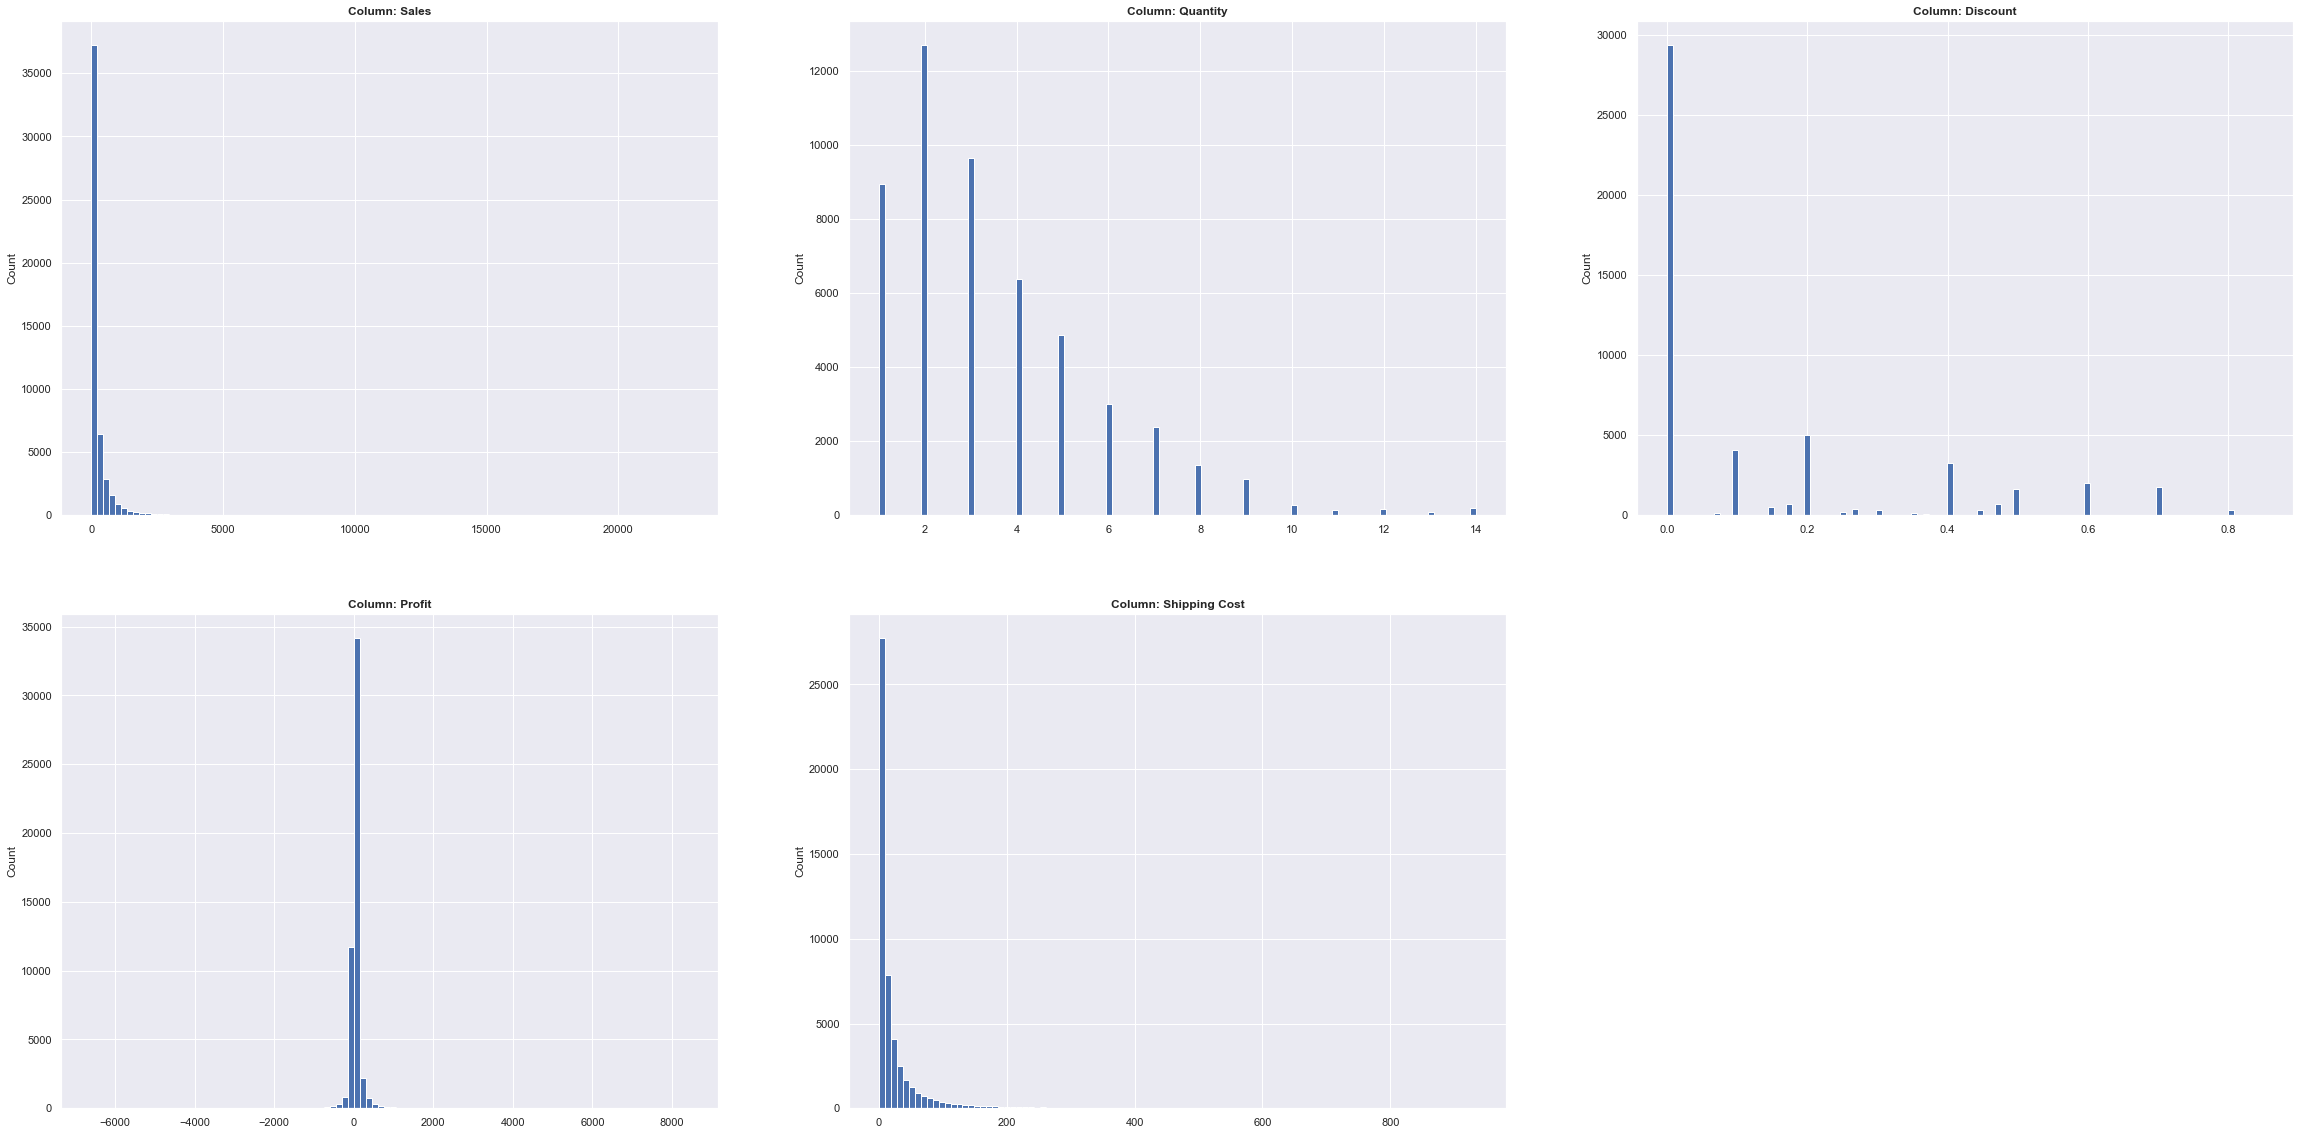

In [37]:
cols = ["Sales", "Quantity", "Discount", "Profit", "Shipping Cost"]
fig_nr_columns = 3
fig_nr_rows = 1 + (len(cols) // fig_nr_columns) if len(cols) % fig_nr_columns != 0 else len(cols) // fig_nr_columns
fig = plt.figure(1, figsize=[40,20])

for k in range(len(cols)):
    num_bins = 100
    ax = fig.add_subplot(fig_nr_rows, fig_nr_columns, k+1)
    ax.hist(df[cols[k]], num_bins)
    plt.title("Column: {}".format(cols[k]), fontweight='bold')
    plt.ylabel("Count")

plt.show()

##### We can clearly see that for the columns Sales, Profit ans Shipping Cost, the range of possible values is very broad, however, theres is an obvious councentration of the values around certain values. Let's try to look at this data reducing the range of values

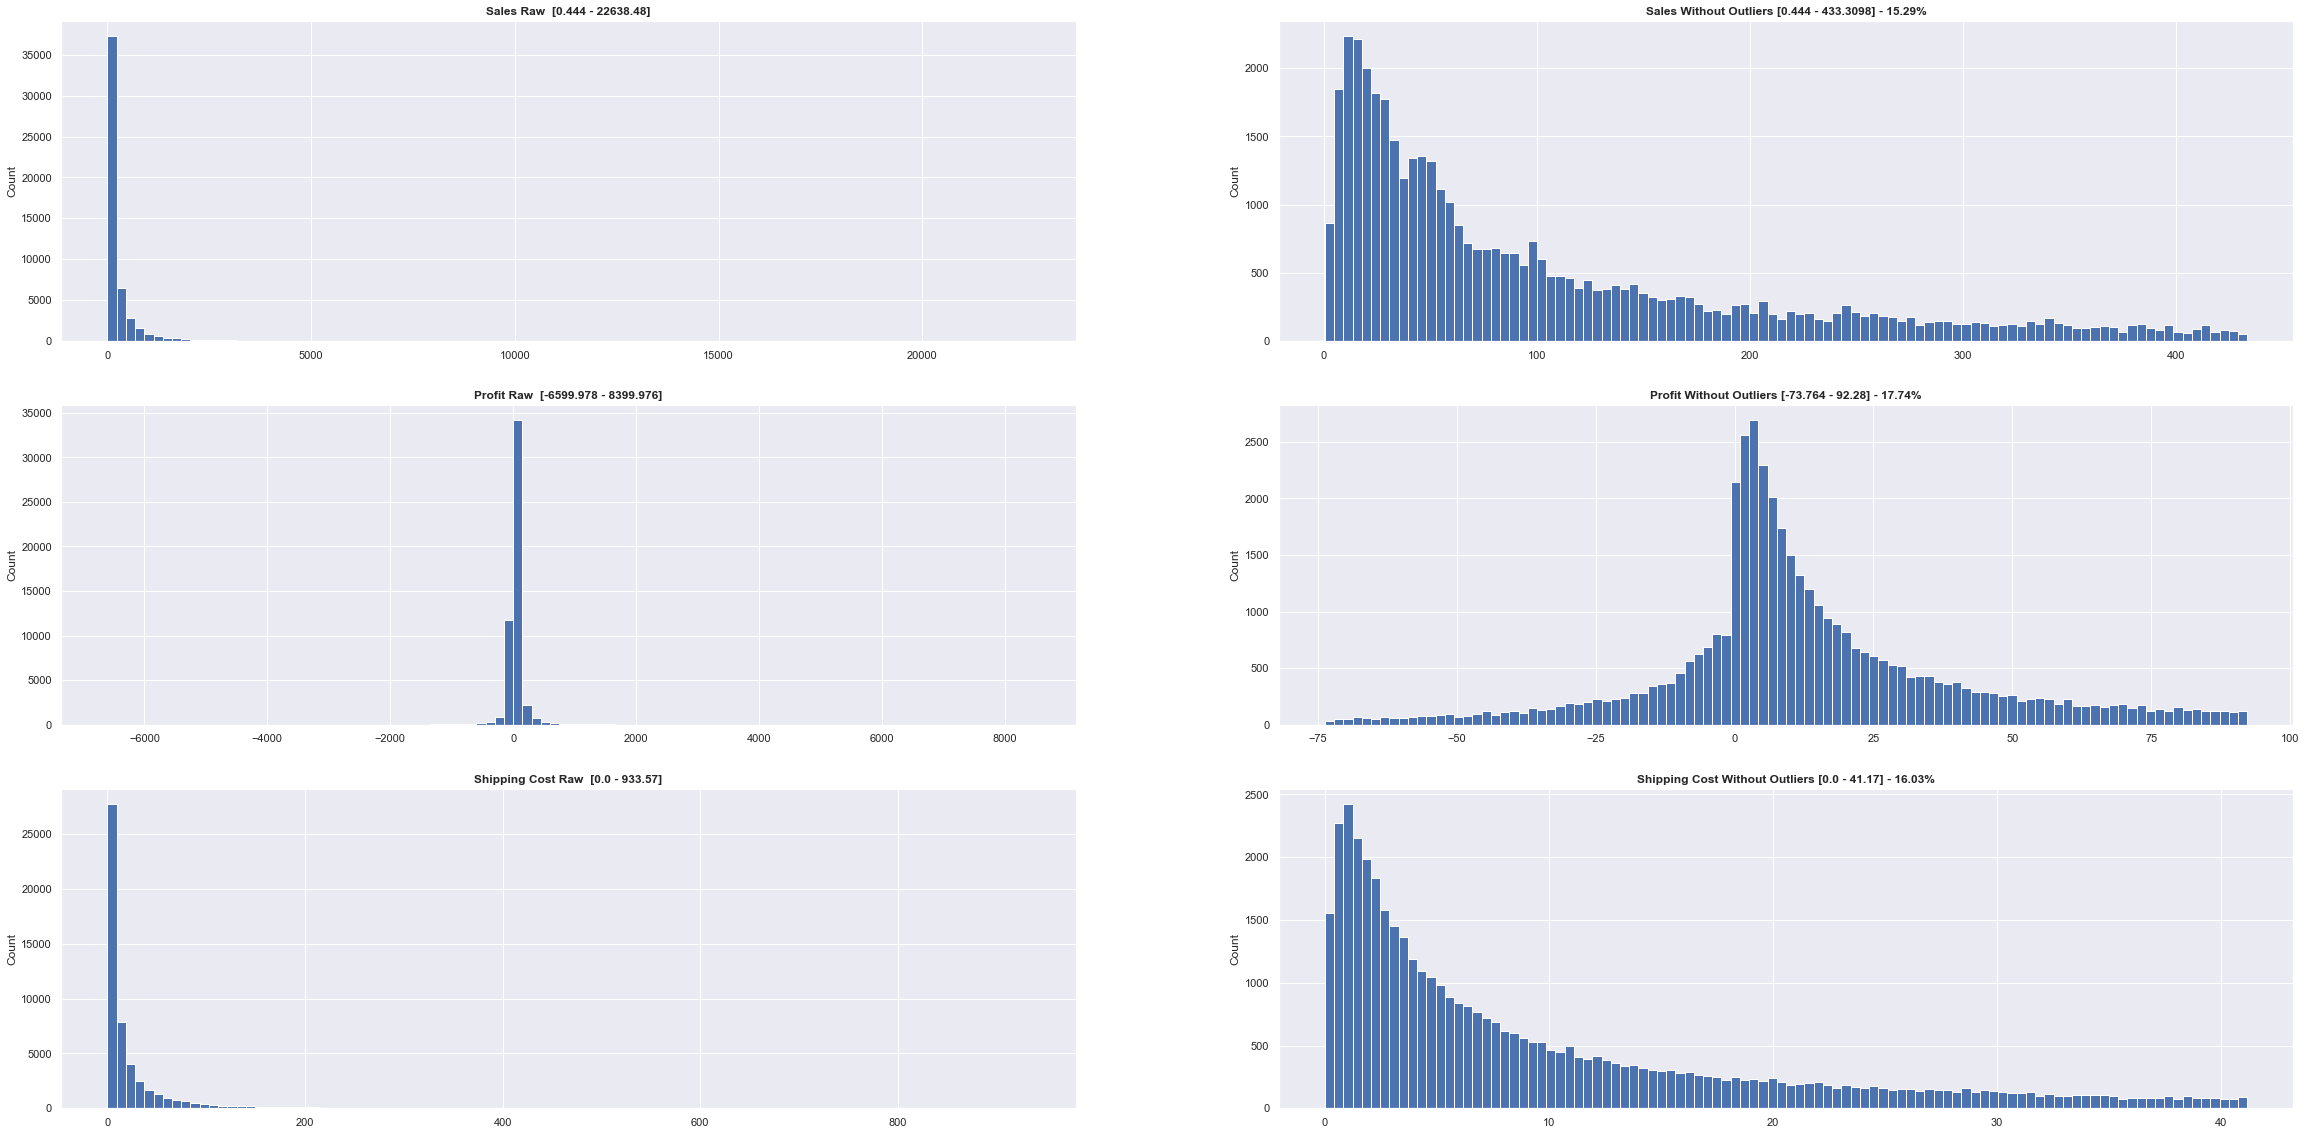

In [41]:
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

cols = ["Sales", "Profit", "Shipping Cost"]
fig_nr_columns = 2
fig_nr_rows = 3
c = 0
fig = plt.figure(1, figsize=[40,20])
for k in range(0,6,2):
    num_bins = 100
    ax = fig.add_subplot(fig_nr_rows, fig_nr_columns, k+1)
    yvalues = np.array(df[cols[c]].dropna())
    ax.hist(yvalues, num_bins)
    plt.title("{} Raw  [{} - {}]".format(cols[c], yvalues.min(), yvalues.max()), fontweight='bold')
    plt.ylabel("Count")
    
    ax = fig.add_subplot(fig_nr_rows, fig_nr_columns, k+2)
    yvalues_outliers = yvalues[~is_outlier(yvalues)]
    percenteOutliers = ( 1 - ( len(yvalues_outliers)/len(yvalues) ) ) * 100
    ax.hist(yvalues_outliers, num_bins)
    plt.title("{} Without Outliers [{} - {}] - {}%".format(cols[c], yvalues_outliers.min(), yvalues_outliers.max(),round(percenteOutliers,2)), fontweight='bold')
    plt.ylabel("Count")
    c += 1
plt.show()

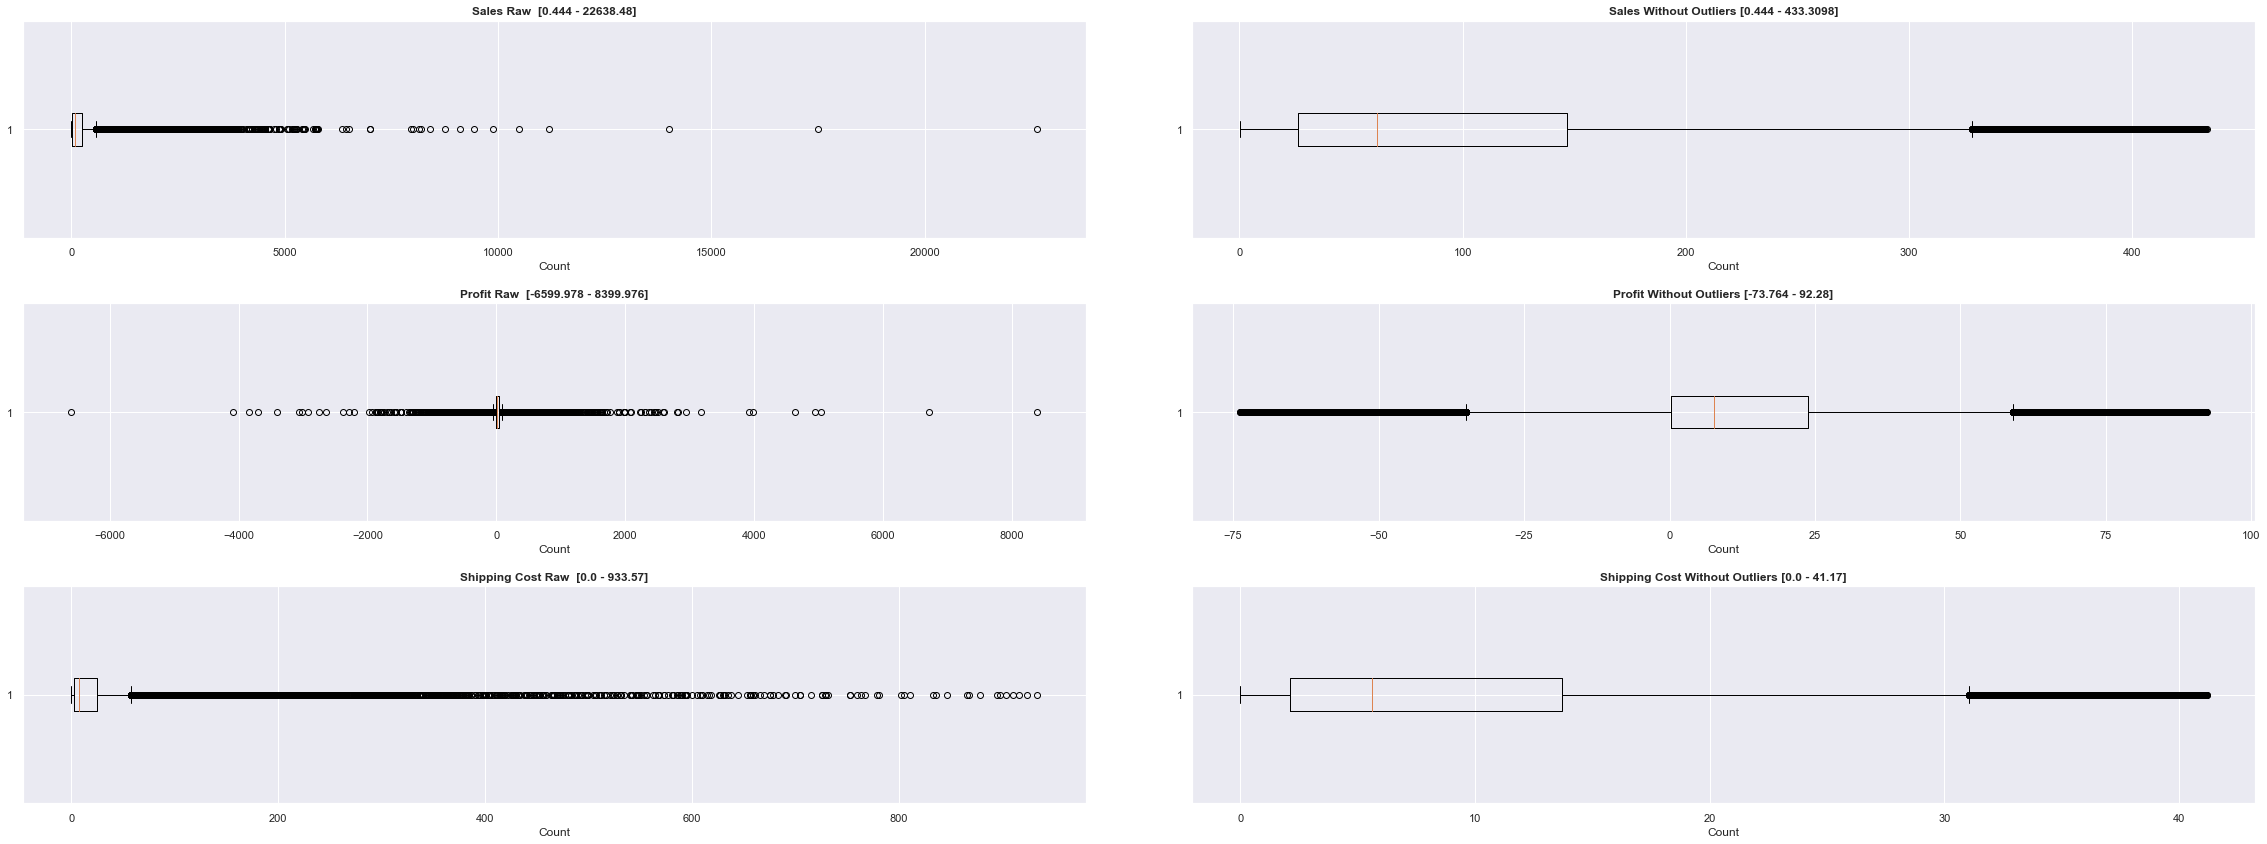

In [39]:
cols = ["Sales", "Profit", "Shipping Cost"]
fig_nr_columns = 2
fig_nr_rows = 6
c = 0
fig = plt.figure(1, figsize=[40,30])
for k in range(0,6,2):
    num_bins = 100
    plt.subplots_adjust(hspace=0.3, wspace=0.1)
    ax = fig.add_subplot(fig_nr_rows, fig_nr_columns, k+1)
    yvalues = np.array(df[cols[c]].dropna())
    ax.boxplot(yvalues, vert=False)
    plt.title("{} Raw  [{} - {}]".format(cols[c], yvalues.min(), yvalues.max()), fontweight='bold')
    plt.xlabel("Count")
    
    ax = fig.add_subplot(fig_nr_rows, fig_nr_columns, k+2)
    yvalues_outliers = yvalues[~is_outlier(yvalues)]
    ax.boxplot(yvalues_outliers, vert=False)
    plt.title("{} Without Outliers [{} - {}]".format(cols[c], yvalues_outliers.min(), yvalues_outliers.max()), fontweight='bold')
    plt.xlabel("Count")
    c += 1
plt.show()

#### Distribuição temporal do dataset

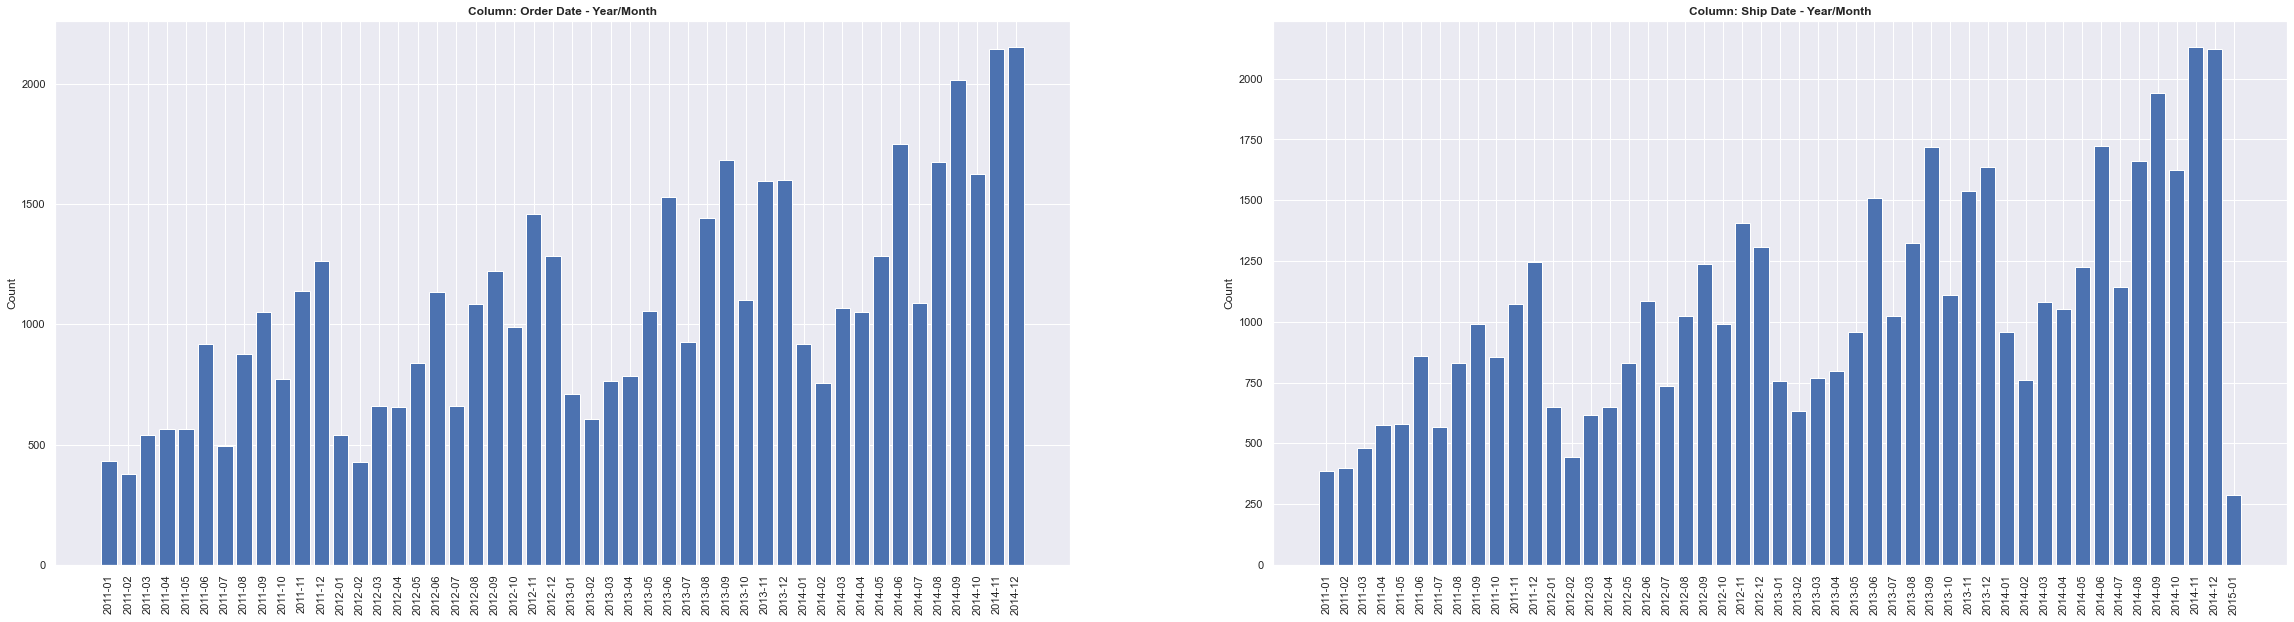

In [40]:
cols = ["Order Date", "Ship Date"]
fig_nr_columns = 2
fig_nr_rows = 1
fig = plt.figure(1, figsize=[40,10])

for k in range(len(cols)):
    col_name = "{} - Year/Month".format(cols[k])
    df[col_name] = df[cols[k]].apply(lambda x: x.strftime('%Y-%m'))
    data_agg = df.groupby(col_name).size().reset_index()
    x = data_agg[col_name]
    y = data_agg[0]
    ypos = np.arange(len(x))
    ax = fig.add_subplot(fig_nr_rows, fig_nr_columns, k+1)
    plt.subplots_adjust(hspace=0.3, wspace=0.2)
    ax.bar(ypos, y)
    ax.tick_params(axis='x', rotation=90)
    plt.xticks(ypos, x)
    plt.title("Column: {}".format(col_name), fontweight='bold')
    plt.ylabel("Count")

plt.show()

We can see that there are records from orders since Jan 2011 up to  Dec 2014. There are some Shipping Date after Dec 2014 that probably result from some of the order on the last days of Dec 2014. There is a upward trend over time, but we can see an yearly cycle that repeats itself, with peaks in the months of Nov December. We will take a look at the monthly trends next

Text(0, 0.5, 'Avg Nr Orders')

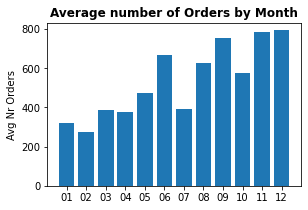

In [15]:
df["Order Month"] = df["Order Date"].apply(lambda x: x.strftime('%m'))
df["Order Year"] = df["Order Date"].apply(lambda x: x.strftime('%Y'))
df["Order Weekday"] = df["Order Date"].apply(lambda x: x.strftime('%A'))

data_agg = df.groupby(["Order Month", "Order Year"])["Order ID"].nunique().reset_index()
data_agg = data_agg.groupby("Order Month")["Order ID"].mean().reset_index()

x = data_agg["Order Month"]
y = data_agg["Order ID"]
ypos = np.arange(len(x))

fig = plt.figure(1, figsize=[10,3])
ax = fig.add_subplot(1, 2, 1)
plt.bar(ypos, y)
plt.xticks(ypos, x)
plt.title("Average number of Orders by Month", fontweight='bold')
plt.ylabel("Avg Nr Orders")

#data_agg = df.groupby(["Order Weekday"])["Order ID"].mean().reset_index()
#
#x = data_agg["Order Weekday"]
#y = data_agg["Order ID"]
#ypos = np.arange(len(x))
#ax = fig.add_subplot(1, 2, 2)
#plt.bar(ypos, y)
#plt.xticks(ypos, x)
#plt.title("Average number of Orders by Month", fontweight='bold')
#plt.ylabel("Avg Nr Orders")
#plt.show()

On the previous chart we can tell that throughout the years, the average number of orders in each month is significantly different. For example, we can see that, on average, the months of Novembember/December has almost double the number of orders then January

Analisando cada uma das colunas:
- Quantity, faz sentido juntar os que estão no máximo, a partir do 10.
- Discount, faz sentido fazer bins por regiões, tipo 0 a 0.2, 0.2 a 0.4, ... Assim não perdemos muita informação.
- Profit, remover outliers, acho.
- Shipping cost, meter mais de 200 para uma categoria.

Postal code não devia ser visto assim :)

<AxesSubplot:>

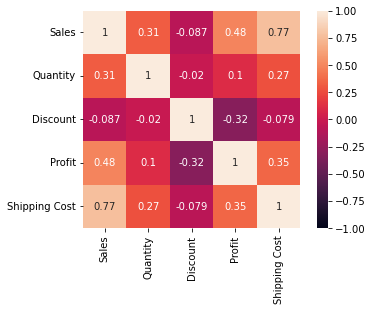

In [16]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix, vmin=-1, vmax=1, square=True,annot=True)

Como podemos ver, existe bastante correlação entre o shipping cost e as sales, logo provavelmente poderemos remover uma das colunas. 
Depois de converter colunas, e converter algumas para números, talvez voltar a relacionar.

É preciso normalizar para meter na matriz? :eyes:


Coluna:  Sales


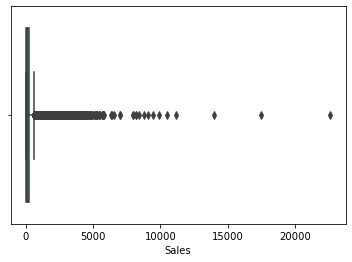


Coluna:  Quantity


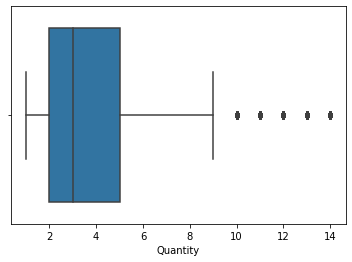


Coluna:  Discount


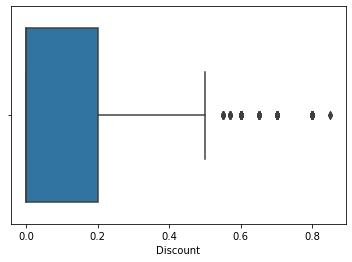


Coluna:  Profit


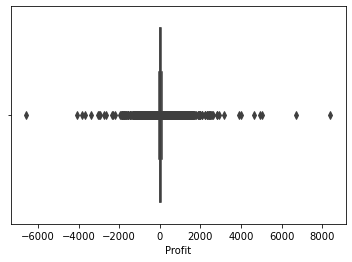


Coluna:  Shipping Cost


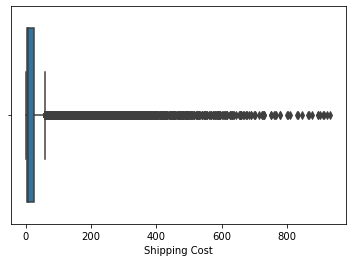

In [17]:
# Análise de dispersão de dados
for coluna in df.select_dtypes(include=["number","float64"]).columns:
    print("\nColuna: ", coluna)
    sns.boxplot(x = df[coluna])
    plt.show()

### Pela análise dos gráficos:
- Postal code: É ignorar
- Sales : Ou dividimos por bins, ou removemos outilers, mas são demasiados
- Quantity remover outliers superiores
- Discount igual
- Profit, aproveitar para analisar que se calhar é normalizado


Coluna:  Sales


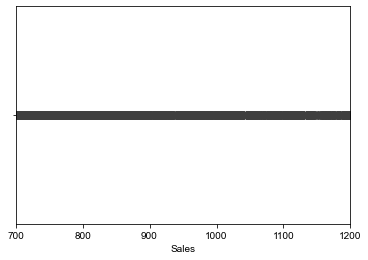


Coluna:  Profit


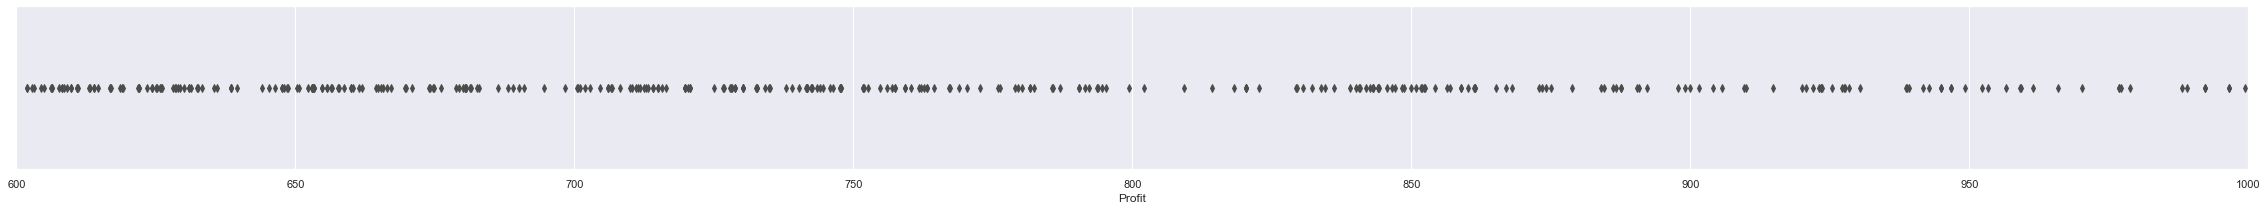


Coluna:  Shipping Cost


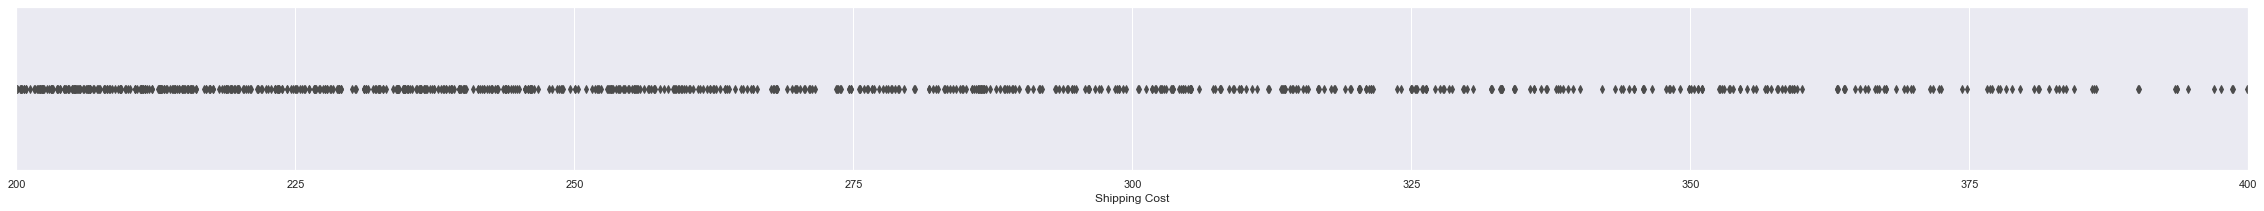

In [18]:
data2 = df[["Sales", "Profit", "Shipping Cost"]]

for coluna in data2.columns:
    print("\nColuna: ", coluna)
    sns.boxplot(x = df[coluna])
    sns.set(rc={'figure.figsize':(40,3)})
    if coluna=="Sales":
        plt.xlim(700,1200)
    if coluna=="Profit":
        plt.xlim(600,1000)
    if coluna=="Shipping Cost":
        plt.xlim(200,400)
    plt.show()

In [19]:
array = []

for num in df[["Sales", "Profit", "Shipping Cost"]]:
    Q1 = df[num].quantile(0.25)
    Q3 = df[num].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    array.append((num,lower,upper))

print(array)

count = 0
for num1 in df[["Sales", "Profit", "Shipping Cost"]]:
    if num1 == "Sales":
        print("oi")
        
    if num1 == "Profit":
        print("oi")
        
    if num1 == "Shipping Cost":
        print("oi")
    

[('Sales', -300.26, 582.78), ('Profit', -55.26225000000001, 92.10375000000002), ('Shipping Cost', -30.245, 57.395)]
oi
oi
oi


In [20]:
# Tratar das datas
data2 = df

if "Order Date" in data2:
    consider_year = True
    consider_month = True
    consider_day = True
else: 
    consider_year = False
    consider_month = False
    consider_day = False
    
# Converter datas, acho que já está feito em cima, depois confirmar
dates_order = DatetimeIndex(pd.to_datetime(data2['Order Date'],format='%d-%m-%Y', errors='coerce'))
dates_ship = DatetimeIndex(pd.to_datetime(data2['Ship Date'],format='%d-%m-%Y', errors='coerce'))
if consider_year : 
    data2['Year_order'] = dates_order.year
    data2['Year_ship'] = dates_ship.year
    
if consider_month : 
    data2['Month_order'] = dates_order.month
    data2['Month_ship'] = dates_ship.month

if consider_day : 
    data2['Day_order'] = dates_order.day
    data2['Day_ship'] = dates_ship.day
if 'Order Date' in data2:
    data2 = data2.drop(['Order Date', 'Ship Date'], axis=1)

df = data2

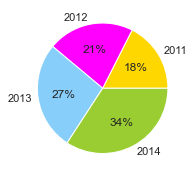

In [21]:
import matplotlib.pyplot as plt
import numpy as np

colors=['gold', 'magenta','lightskyblue', 'yellowgreen']

# estamos a agrupar por year order e a contar o numero de order id. O reset index é para tirar o year_order de index e voltar a ser 0,1,2,3,4
data = df.groupby(['Year_order'])['Order ID'].count().reset_index()

plt.pie(data['Order ID'], labels = data['Year_order'], colors = colors, autopct='%.0f%%')
plt.show()


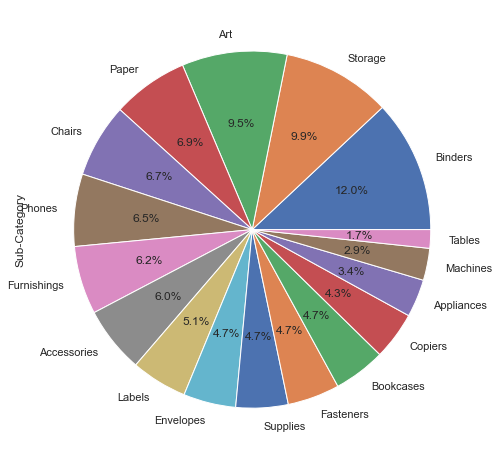

In [22]:
plt.figure(figsize=(8,15))
df['Sub-Category'].value_counts().plot.pie(autopct = "%1.1f%%")
plt.show()

A partir deste gráfico de pizza, podemos retirar que vendas de binders é a maior e venda de tables é a menor na Global Superstore.

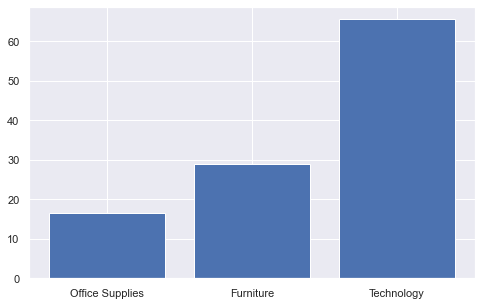

In [23]:
highest_category_profit = df.groupby(by=['Category']).mean().sort_values(by=['Profit']).reset_index()
plt.figure(figsize=(8,5))
plt.bar("Category",'Profit',data=highest_category_profit)
plt.show()

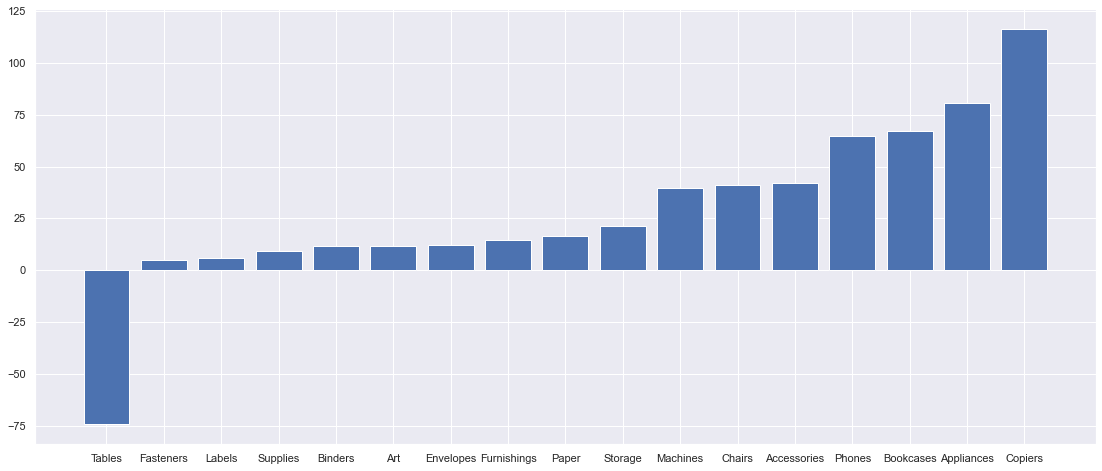

In [24]:
highest_category_profit = df.groupby(by=['Sub-Category']).mean().sort_values(by=['Profit']).reset_index()
plt.figure(figsize=(19,8))
plt.bar("Sub-Category",'Profit',data=highest_category_profit)
plt.show()

In [25]:
result=df.columns
print(result)

Index(['Order ID', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment',
       'City', 'State', 'Country', 'Postal Code', 'Market', 'Region',
       'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Sales',
       'Quantity', 'Discount', 'Profit', 'Shipping Cost', 'Order Priority',
       'Order Date - Year/Month', 'Ship Date - Year/Month', 'Order Month',
       'Order Year', 'Order Weekday', 'Year_order', 'Year_ship', 'Month_order',
       'Month_ship', 'Day_order', 'Day_ship'],
      dtype='object')



Ano:  2011


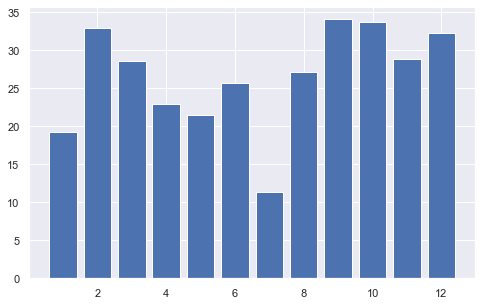


Ano:  2012


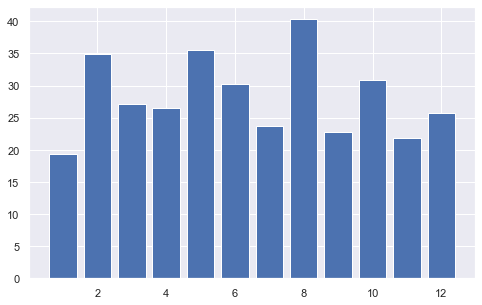


Ano:  2013


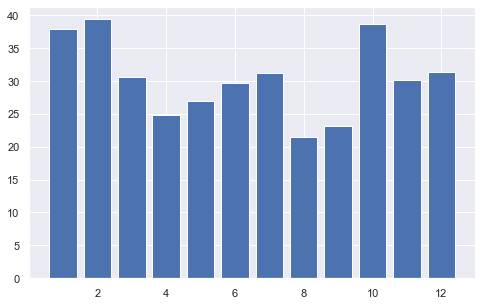


Ano:  2014


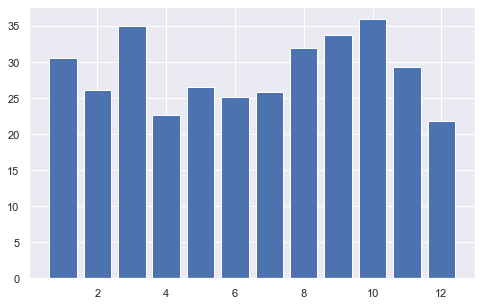

In [26]:
years=[2011,2012,2013,2014]

for year in years:
    month = df[df["Year_order"] == year].groupby(by=['Month_order'])["Profit"].mean().reset_index()
    plt.figure(figsize=(8,5))
    plt.bar('Month_order','Profit',data=month)
    print("\nAno: ", year)
    plt.show()